#DETR Finetune assignment
## By: Jeremy Rico
## Organization: TypeFace

Description:

This script finetunes the DETR object detection for two classes of the COCO

dataset, 'banana' and 'cat'

Official DETR repository: https://github.com/facebookresearch/detr

### Clone my repo for downloading coco annotations and images

In [1]:
!git clone https://github.com/jeremy-rico/DETR_finetune.git
%cd DETR_finetune

Cloning into 'DETR_finetune'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 50 (delta 21), reused 40 (delta 11), pack-reused 0
Receiving objects: 100% (50/50), 8.05 MiB | 22.04 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/DETR_finetune


### Download necessary content

This script does a few things:

1. Downloads the COCO2017 train_val annotations
2. Creates a subset of the data which includes 100 samples of two classes and splits then using a 70, 15, 15 split ratio
3. Downloads pretrained DETR-50 weights and removes the classification head


In [2]:
!python3 download.py \
  --classes cat banana \
  --num_samples 100 \
  --split 0.7 0.15 0.15 \
  --coco_type trainval2017 \
  --out_dir data

Extracting annotations to data/annotations_trainval2017
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
Preparing custom dataset...
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100% 159M/159M [00:00<00:00, 207MB/s]


## Data Exploration

Lets look over some of the data to make sure the download script worked properly

In [3]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
from pathlib import Path
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
dataDir=Path('/content/DETR_finetune/data/custom/')
dataType='train'
annFile=dataDir / f'annotations/custom_{dataType}.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print(f'Categories: {nms}')

nms = set([cat['supercategory'] for cat in cats])
print(f'Super-categories: {nms}')

Categories: ['cat', 'banana']
Super-categories: {'animal', 'food'}


Lets take a look at a few of each of out classes

In [6]:
def show_img(img_id, dataDir, dataType):
  plt.figure
  img = coco.loadImgs(img_id)[0]
  img_name = os.path.join(dataDir, f'{dataType}2017', img['file_name'])
  print(f"Image id: {img_id}")
  print(f"Image name: {img_name.split('/')[-1]}")

  annIds = coco.getAnnIds(imgIds=img['id'])
  anns = coco.loadAnns(annIds)
  I = io.imread(img_name)
  plt.imshow(I)
  coco.showAnns(anns, draw_bbox=True)

### Cat Example

Image id: 469067
Image name: 000000469067.jpg


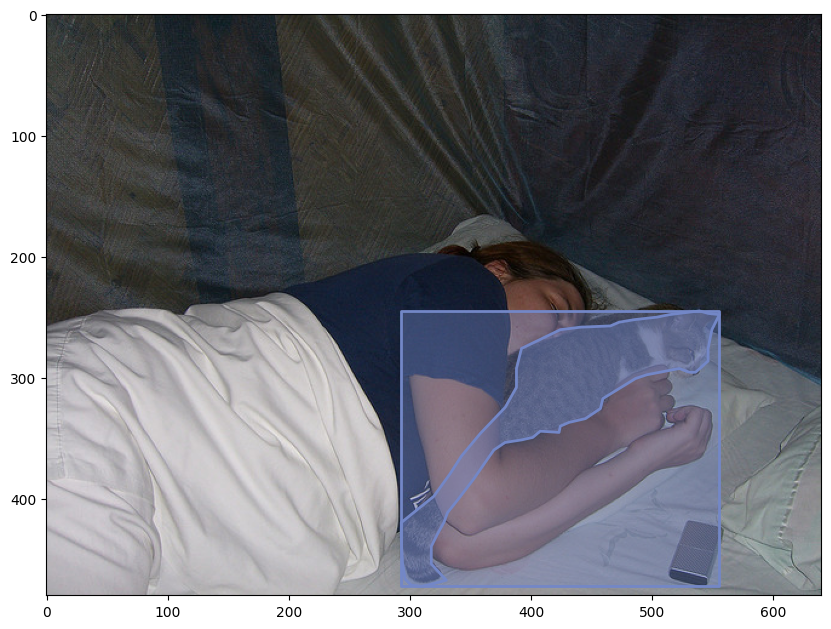

In [7]:
# load and display image
cat_catId = coco.getCatIds(catNms=['cat'])
imgIds = coco.getImgIds(catIds=cat_catId);
img_id = imgIds[np.random.randint(0,len(imgIds))]
show_img(img_id, dataDir, dataType)

### Banana Example

Image id: 453708
Image name: 000000453708.jpg


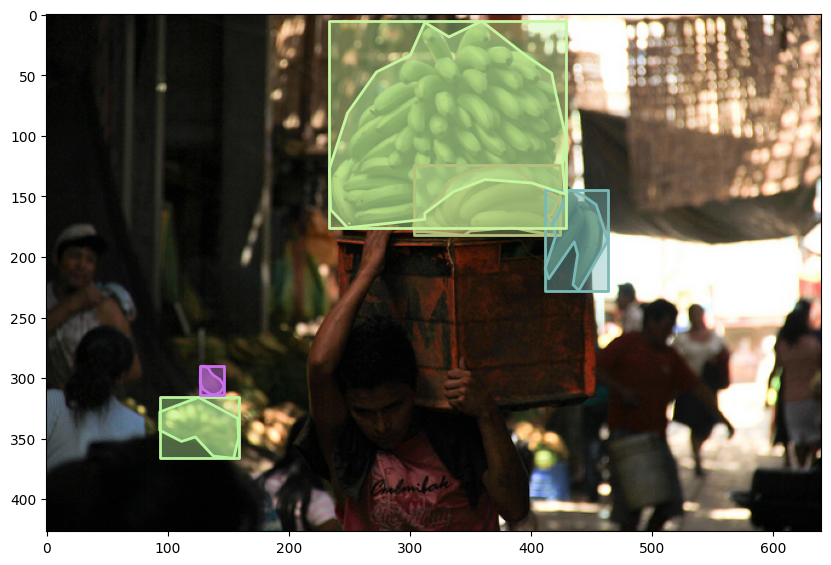

In [8]:
banana_catId = coco.getCatIds(catNms=['banana'])
imgIds = coco.getImgIds(catIds=banana_catId);
img_id = imgIds[np.random.randint(0,len(imgIds))]
show_img(img_id, dataDir, dataType)

## Difficulties of the banana class
Banana has proven to be a very difficult class. Mainly becuase of the amount of forms it can appear in and discrepencies in labeling. Banana appears in multiple forms:
* Bunch
* Single (peeled, unpeeled, partially peeled)
* Sliced (cooked, uncooked)

This variation makes it a difficult class to learn. Below are some examples.

For this reason I trained for 25 epochs instead of 10 which would have been fine for an easier class.

Bunched:
Image id: 161820
Image name: 000000161820.jpg


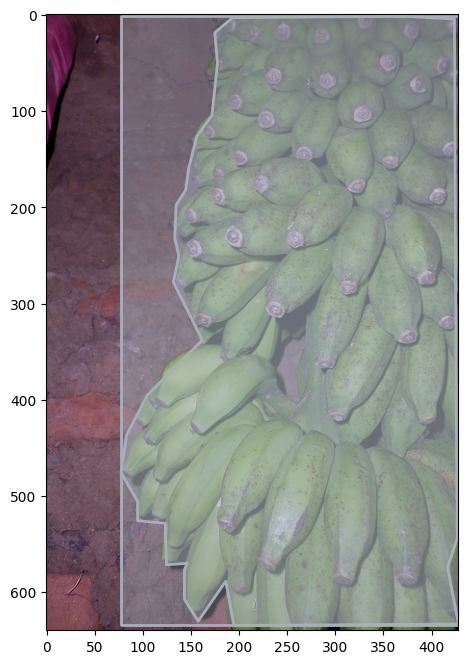

In [9]:
bunch_id = 161820
print("Bunched:")
show_img(bunch_id, dataDir, dataType)

Peeled:
Image id: 474854
Image name: 000000474854.jpg


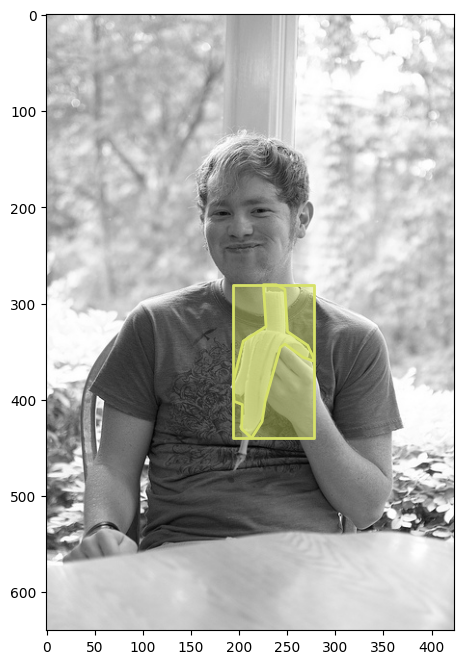

In [10]:
peeled_id = 474854
print("Peeled:")
show_img(peeled_id, dataDir, dataType)

Sliced:
Image id: 489305
Image name: 000000489305.jpg


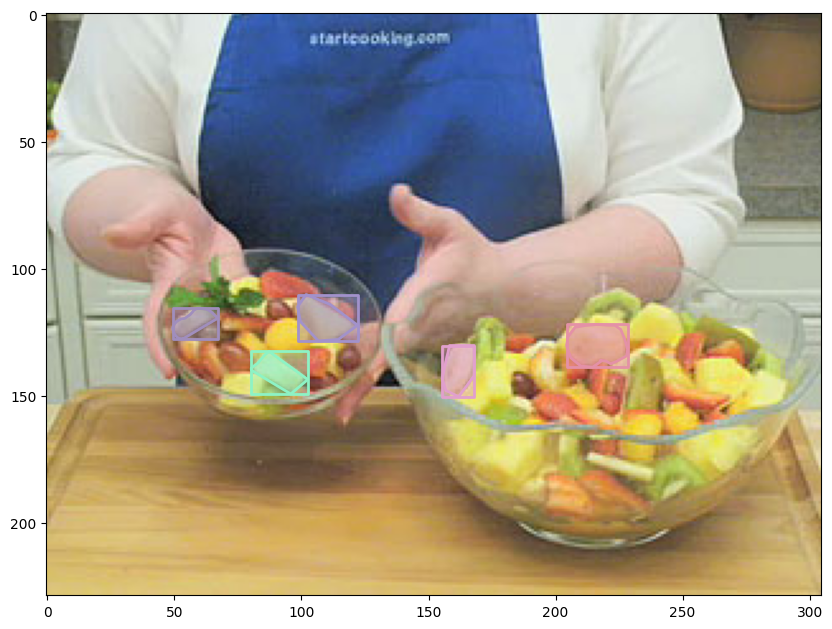

In [11]:
sliced_id = 489305
print("Sliced:")
show_img(sliced_id, dataDir, dataType)

wtf:
Image id: 90891
Image name: 000000090891.jpg


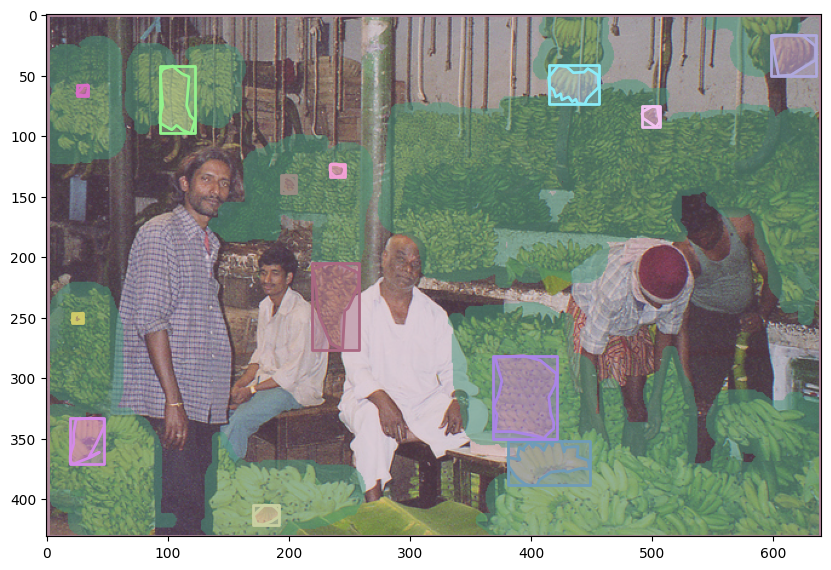

In [12]:
wtf_id = 90891
print("wtf:")
show_img(wtf_id, dataDir, dataType)

#Training

First we will clone the finetuning fork by woctezuma

Source: https://github.com/woctezuma/detr

In [13]:
!git clone https://github.com/woctezuma/detr.git
%cd detr
!git checkout finetune

Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 323.68 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/content/DETR_finetune/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


Define our number of classes and names (num_classes can be 2 since we began our indexing at 0 in download.py)

In [14]:
num_classes = 2
finetuned_classes = ['cat', 'banana']
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
out_dir = "/content/DETR_finetune/outputs"

Train!
(I cleared the output of this cell since it was way too long)

In [20]:
!python3 main.py \
  --dataset_file "custom" \
  --coco_path "/content/DETR_finetune/data/custom/" \
  --output_dir $out_dir \
  --resume "/content/DETR_finetune/model/detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --device cpu \
  --epochs 25

Not using distributed mode
git:
  sha: 3cda3529921efb8870d0b49db7b30aa8477ae359, status: clean, branch: finetune

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=25, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, num_classes=2, dataset_file='custom', coco_path='/content/DETR_finetune/data/custom/', coco_panoptic_path=None, remove_difficult=False, output_dir='/content/DETR_finetune/outputs', device='cpu', seed=42, resume='/content/DETR_finetune/model/detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-

In [16]:
from util.plot_utils import plot_logs
from pathlib import Path

log_directory = [Path(out_dir)]

In [17]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

-> missing log.txt.  Have you gotten to Epoch 1 in training?
--> full path of missing log file: /content/DETR_finetune/outputs/log.txt


In [18]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

-> missing log.txt.  Have you gotten to Epoch 1 in training?
--> full path of missing log file: /content/DETR_finetune/outputs/log.txt


#Inference

In [19]:
import torch
from PIL import Image
import random
import matplotlib.pyplot as plt
import torchvision.transforms as T

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load(os.path.join(out_dir, 'checkpoint.pth'),
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FileNotFoundError: ignored

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):

  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled

def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.7]:
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)
    plot_finetuned_results(my_image,
                           probas_to_keep,
                           bboxes_scaled)

def get_test_img(coco, category, dataDir):
  catId = coco.getCatIds(catNms=[category])
  imgIds = coco.getImgIds(catIds=catId)
  img_id = random.choice(imgIds)
  img = coco.loadImgs(img_id)[0]
  return os.path.join(dataDir, f'test2017', img['file_name'])

In [ ]:
test_annFile = os.path.join(dataDir, f'annotations/custom_test.json')
test_coco = COCO(test_annFile)

test_img_name = get_test_img(test_coco, 'cat', dataDir)
im = Image.open(test_img_name)
run_worflow(im,
            model)

In [ ]:
test_img_name = get_test_img(test_coco, 'banana', dataDir)
im = Image.open(test_img_name)
run_worflow(im,
            model)

#F1-score for inference images
This function runs inference on all test images, and calculates an F1 score for each class. It uses L1 loss since we do not have to account for image sizes for the purposes of this assignment.

Conf thresh = 0.7
L1 loss thresh = 0.8

Hungarian Matcher util stolen from source repo

In [ ]:
from scipy.optimize import linear_sum_assignment

class HungarianMatcher(nn.Module):
    """This class computes an assignment between the targets and the predictions of the network

    For efficiency reasons, the targets don't include the no_object. Because of this, in general,
    there are more predictions than targets. In this case, we do a 1-to-1 matching of the best predictions,
    while the others are un-matched (and thus treated as non-objects).
    """

    def __init__(self, cost_class: float = 1, cost_bbox: float = 1)#, cost_giou: float = 1):
        """Creates the matcher

        Params:
            cost_class: This is the relative weight of the classification error in the matching cost
            cost_bbox: This is the relative weight of the L1 error of the bounding box coordinates in the matching cost
            cost_giou: This is the relative weight of the giou loss of the bounding box in the matching cost
        """
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        #self.cost_giou = cost_giou
        assert cost_class != 0 or cost_bbox != 0, "all costs cant be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        """ Performs the matching

        Params:
            outputs: This is a dict that contains at least these entries:
                 "pred_logits": Tensor of dim [batch_size, num_queries, num_classes] with the classification logits
                 "pred_boxes": Tensor of dim [batch_size, num_queries, 4] with the predicted box coordinates

            targets: This is a list of targets (len(targets) = batch_size), where each target is a dict containing:
                 "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth
                           objects in the target) containing the class labels
                 "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates

        Returns:
            A list of size batch_size, containing tuples of (index_i, index_j) where:
                - index_i is the indices of the selected predictions (in order)
                - index_j is the indices of the corresponding selected targets (in order)
            For each batch element, it holds:
                len(index_i) = len(index_j) = min(num_queries, num_target_boxes)
        """
        bs, num_queries = outputs["pred_logits"].shape[:2]

        # We flatten to compute the cost matrices in a batch
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)  # [batch_size * num_queries, num_classes]
        out_bbox = outputs["pred_boxes"].flatten(0, 1)  # [batch_size * num_queries, 4]

        # Also concat the target labels and boxes
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        # Compute the classification cost. Contrary to the loss, we don't use the NLL,
        # but approximate it in 1 - proba[target class].
        # The 1 is a constant that doesn't change the matching, it can be ommitted.
        cost_class = -out_prob[:, tgt_ids]

        # Compute the L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)

        # Compute the giou cost betwen boxes
        #cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))

        # Final cost matrix
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class #+ self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]


def build_matcher(args):
    return HungarianMatcher(cost_class=args.set_cost_class, cost_bbox=args.set_cost_bbox)#, cost_giou=args.set_cost_giou)

In [ ]:
import torch.nn.functional as F
from .model.matcher import HungarianMatcher
def f1_score(coco, model, dataDir):
  f1_dict = {}
  cats = coco.loadCats(coco.getCatIds())
  for cat in cats:
    outputs = {
        'pred_logits': [],
        'pred_bboxes': [],
        'labels': [],
        'bboxes': []
    }
    #f1_dict[cat['name']] = {'tp':0, 'fp':0, 'tn':0, 'fn':0}
    imgIds = coco.getImgIds(catIds=cat["id"])
    for imgId in imgIds:
      test_img = coco.loadImgs(imgId)[0]
      img_name = os.path.join(dataDir, f'test2017', test_img['file_name'])
      im = Image.open(img_name)
      img = transform(im).unsqueeze(0)

      # propagate through the model
      outputs = model(img)
      conf_thresh = 0.70
      probas, bboxes_pred = filter_bboxes_from_outputs(outputs,
                                                  threshold=conf_thresh)

      # get labeled box coords
      annIds = coco.getAnnIds(imgIds=imgId)
      anns = coco.loadAnns(annIds)
      for ann in anns:
        bboxes_true = torch.FloatTensor(ann['bbox']).view(bboxes_pred.shape)
        loss = F.l1_loss(bboxes_pred, bboxes_true)
        print(loss)


f1 = f1_score(test_coco, model, dataDir)